In [100]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

In [57]:
data_raw = pd.read_csv("../data/clean/full_dataset.csv")

In [58]:
data_raw.head()

,ID Number,Preferred Pronouns,Current Grade Level,Program,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Uncomfortable with,Extra activities,...,Application Year,Current Age,Rejected,EECode,EarnHours,EarnRate,EarnAmount,Dist Position Desc,Year,Month
0,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,5.50,13.0,71.50,WILD Steward,2022.0,4.0
1,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,14.47,13.0,188.11,WILD Steward,2022.0,5.0
2,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,7.13,13.0,92.69,WILD Steward,2022.0,5.0
3,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,130.38,13.0,1694.94,WILD Steward,2022.0,6.0
4,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,123.80,13.0,1609.40,WILD Steward,2022.0,7.0


In [59]:
data_raw.columns

Index(['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode', 'EarnHours', 'EarnRate', 'EarnAmount', 'Dist Position Desc',
       'Year', 'Month'],
      dtype='object')

## Calculate monthly hours

In [60]:
#Sum up monthly earn hours
hours = data_raw[['ID Number','EarnHours','Year','Month']]
hours = hours.dropna().reset_index(drop = True)

In [68]:
hours_sum = hours.groupby(['ID Number','Year','Month']).agg({'EarnHours':'sum'}).add_suffix('_Sum').reset_index()
hours_sum = hours_sum.groupby(['ID Number']).agg({'EarnHours_Sum':'mean'}).add_suffix('_AvgPerMonth').reset_index()
hours_sum
#hours_sum.groupby(['ID Number']).rank(method='dense')
#hours_sum.pivot(index = 'ID Number', columns={'Year','Month'}, values='EarnHours_Sum')

,ID Number,EarnHours_Sum_AvgPerMonth
0,1154.0,24.831667
1,1155.0,25.070000
2,1156.0,27.921429
3,1158.0,37.409200
4,1160.0,40.462222
5,1161.0,36.945556
6,1162.0,33.465000
7,1163.0,44.670000
8,1164.0,76.846364
9,1165.0,20.953750


## Condense dataframe

In [155]:
# remove info on hours and dedupe
data = data_raw[['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode']]

data = data.drop_duplicates().reset_index(drop=True)

# bring in summarized hours
data = data.merge(hours_sum, on=['ID Number'], how="left")

# fill unknown values
data = data.fillna(value='unknown')

# one-hot encode values
data = pd.get_dummies(data, columns = ['Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age'])

## Define X, y

In [118]:
data.columns

Index(['ID Number', 'Rejected', 'EECode', 'EarnHours_Sum_AvgPerMonth',
       'Preferred Pronouns_feminine', 'Preferred Pronouns_masculine',
       'Preferred Pronouns_neutral', 'Preferred Pronouns_unknown',
       'Current Grade Level_8.0', 'Current Grade Level_9.0',
       'Current Grade Level_10.0', 'Current Grade Level_11.0',
       'Current Grade Level_12.0', 'Current Grade Level_unknown',
       'Program_homeschool', 'Program_other', 'Program_unknown',
       'Program_zoocamp', 'First Paying Job_0', 'First Paying Job_1',
       'Know employee_0', 'Know employee_1', 'Applied Before_0',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Comfortable speaking to crowd_unknown', 'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Uncomfortable with_unknown', 'Extra activities_0',
       'Extra activit

In [156]:
# Drop a column from one hot encoded values, specifically drop the _unknown columns where possible
X = data[['Preferred Pronouns_feminine', 'Preferred Pronouns_masculine',
       'Preferred Pronouns_neutral',
       'Current Grade Level_8.0', 'Current Grade Level_9.0',
       'Current Grade Level_10.0', 'Current Grade Level_11.0',
       'Current Grade Level_12.0',
       'Program_homeschool', 'Program_other',
       'Program_zoocamp', 'First Paying Job_1',
       'Know employee_1',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Extra activities_1', 'Commit Summer_unsure',
       'Commit Summer_yes', 'Commit Weekday_no',
       'Commit Weekday_unsure', 'Commit Weekday_yes',
       'Hear about source_family', 'Hear about source_friend',
       'Hear about source_other', 'Hear about source_school',
       'Hear about source_social media',
       'Application Year_2021',
       'Application Year_2022', 'Current Age_12.0', 'Current Age_13.0',
       'Current Age_14.0', 'Current Age_15.0', 'Current Age_16.0',
       'Current Age_17.0', 'Current Age_18.0', 'Current Age_19.0',
       'Current Age_24.0']]

y = data['Rejected']

## Train model

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [159]:
model.coef_

array([[-0.07767013, -0.77837059,  0.54112603,  0.44479602, -0.53394917,
        -0.23692893, -0.40244559,  0.53472316,  0.20622273, -0.47935357,
         0.31520367, -0.46422997, -0.14762365,  0.02100869,  0.42055835,
        -0.66625079,  0.50336501, -0.41793712,  0.58809176, -0.42537388,
        -0.4114451 ,  0.15235657,  0.36503403, -0.76000648,  0.01131548,
         0.54166679, -0.99577784, -0.50784507,  0.22875374, -0.25463728,
         0.52004926, -0.20444474, -0.06133398, -0.67958039,  0.        ,
         0.31622038,  0.02033771,  0.09988497, -0.48197149,  0.39448804,
         0.15495806,  0.02002283,  0.04486899]])

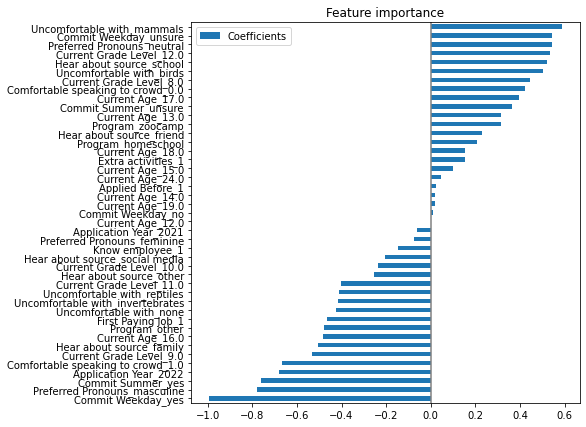

In [160]:
coefs = pd.DataFrame(
   model.coef_.transpose(),
   columns=['Coefficients'], index=X_train.columns
)

coefs = coefs.sort_values(by=['Coefficients'])
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)



In [161]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(231, 43)
(58, 43)
(231,)
(58,)


In [162]:
regr = linear_model.LogisticRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(X) # adding a constant
 
model = sm.Logit(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 [5.13225732]
Coefficients: 
 [[-0.11670074 -0.48980869  0.64973564  0.06779457 -0.43741922 -0.14584792
  -0.43365217  0.68439337 -0.28454762 -0.63366915 -0.23423458 -0.35817248
  -0.46155736  0.09785159  0.00468108 -0.37026728  0.61706867 -0.42852631
   0.3169118  -0.25445649 -0.47666783  0.08038558  0.09020538 -0.64619822
   0.07830747  0.63542494 -1.12496185 -0.43874835  0.30333275 -0.16457778
   0.53335412 -0.56732483 -0.426171   -0.6637005  -0.7679324   0.40040096
  -0.02755911  0.17614086 -0.04336088  0.51596021  0.17689079  0.02044998
   0.0415419 ]]
         Current function value: 0.292420
         Iterations: 35


LinAlgError: Singular matrix

In [66]:

plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [67]:
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

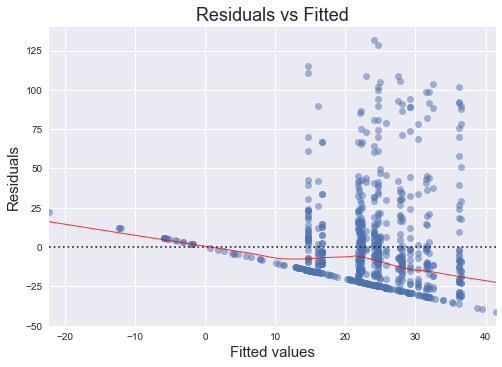

In [68]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

c:\Users\ihkim\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


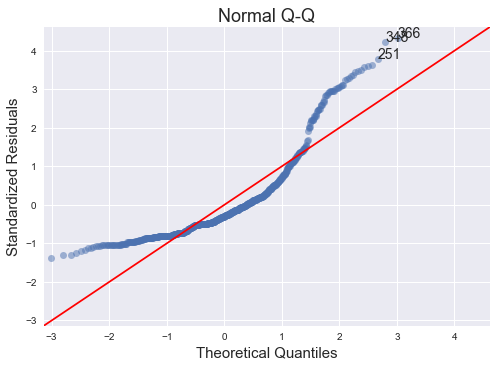

In [69]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]))

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


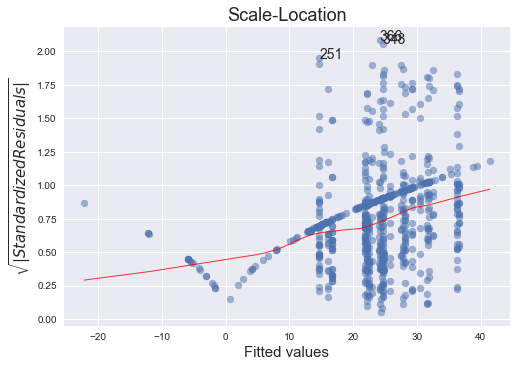

In [70]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                            xy=(model_fitted_y[i],
                            model_norm_residuals_abs_sqrt[i]))

c:\Users\ihkim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


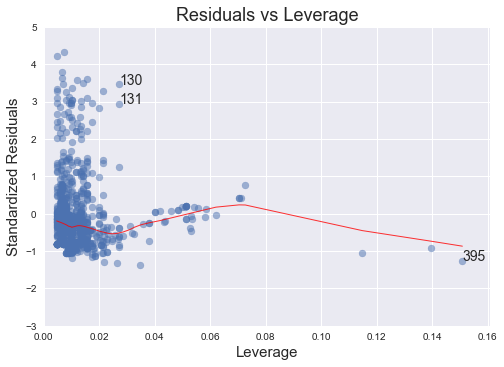

In [71]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
    xy=(model_leverage[i],
        model_norm_residuals[i]))